In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))
    
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from ml.utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores, find_all
import shap
shap.initjs()

from sklearn.metrics import accuracy_score


import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
def merge_strings_and_integers(val):
    try:
        return int(val)
    except:
        return 'other'

In [3]:
df = pd.read_csv("final_autof.csv")
df.drop([
    'MODE(consumptions.MS_METER_NBR)',
    'MODE(representations.SUPPLIER)',
    'MODE(representations.SUPPLIER_TO)',
], axis=1, inplace=True)
df.dropna(subset=['number_of_zeros'], inplace=True)


df['MODE(consumptions.BS_RATE)'] = df['MODE(consumptions.BS_RATE)'].apply(merge_strings_and_integers)
df = df.drop(['rec_id'], axis=1)
df = df.drop_duplicates()
df['MODE(requests.REQUEST_TYPE)'] = df['MODE(requests.REQUEST_TYPE)'].replace(0, 'unknown')
df = pd.get_dummies(df, columns=['MODE(requests.REQUEST_TYPE)'], prefix='MODE(requests.REQUEST_TYPE)')
df = pd.get_dummies(df, columns=['MODE(consumptions.BS_RATE)'], prefix='MODE(consumptions.BS_RATE)')
df = df.drop(['voltage'], axis=1)
df.fillna(0, inplace=True)
df.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def train(clfs, X, y, cols, ensemble='top_per_classifier'):
    acc_scores = []
    prec_scores = []
    rec_scores = []
    f1_scores = []
    brier_scores, auc_roc_scores, pr_auc_scores = [], [], []
    lift_scores, demotion_scores, weighted_scores = [], [], []
    scaler = MinMaxScaler()
    
    assert len(X) == len(y)
    print("Number of samples:", len(X))
    print("Data bins", np.bincount(y))
    
    corrects = dict()
    for split_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
        lifts = dict()
        all_scores = dict()
        
        for clf_name, clf in clfs:
            print("\n\nClassifier:", clf_name)
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    
            
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)

            print("Shape", X_train.shape)


            print("bins", np.bincount(y_train))
            print("bins", np.bincount(y_test))

            clf.fit(X_train, y_train,verbose=False)

            y_pred = clf.predict(X_test)

            acc, precision, recall, f1 = get_classification_metrics(y_test.values, y_pred)

            y_scores = clf.predict_proba(X_test)
            idx = np.argmax(y_scores, axis=1)
            y_scores = np.where(idx == 0, 1 - y_scores[:, 0], y_scores[:, 1])
            
            all_scores[clf_name] = y_scores


            brier, roc_auc, pr_auc = get_probability_measures(y_test.values, y_scores)

            num_ones = np.sum(y_test == 1)


            s1 = int(0.1 * num_ones)
            s2 = int(0.2 * num_ones)
            s3 = int(0.3 * num_ones)
            s4 = int(0.4 * num_ones)
            s5 = int(0.5 * num_ones)
            s6 = int(0.6 * num_ones)
            s7 = int(0.7 * num_ones)
            s8 = int(0.8 * num_ones)
            s9 = int(0.9 * num_ones)
            s10 = int(1 * num_ones)

            lift1, demotion1, weighted_score1 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                        num_samples=s1)
            lift2, demotion2, weighted_score2 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                        num_samples=s2)
            lift3, demotion3, weighted_score3 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                        num_samples=s3)
            lift4, demotion4, weighted_score4 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                        num_samples=s4)
            lift5, demotion5, weighted_score5 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                        num_samples=s5)
            lift6, demotion6, weighted_score6 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                        num_samples=s6)
            lift7, demotion7, weighted_score7 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                        num_samples=s7)
            lift8, demotion8, weighted_score8 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                        num_samples=s8)
            lift9, demotion9, weighted_score9 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                        num_samples=s9)
            lift10, demotion10, weighted_score10 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                        num_samples=s10)
            
            lift100, demotion100, weighted_score100 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                        num_samples=100)

            print(f"At 100 samples -- Lift: {lift100:.4f}, Demotion: {demotion100:.4f}, Weighted: {weighted_score100:.4f}")
            sorted_scores = np.argsort(y_scores.reshape(1, -1)[0])
            top_indices_lift = sorted_scores[-100:]
            lifts[clf_name] = top_indices_lift
            print("Top 10 scores:", y_scores[top_indices_lift][-10:])
            

            acc_scores.append(acc)
            prec_scores.append(precision)
            rec_scores.append(recall)
            f1_scores.append(f1)

            brier_scores.append(brier)
            auc_roc_scores.append(roc_auc)
            pr_auc_scores.append(pr_auc)

            lift_scores.append(lift100)
            demotion_scores.append(demotion100)
            weighted_scores.append(weighted_score100)

            print(f"0.1 -- Lift: {lift1:.4f}, Demotion: {demotion1:.4f}, Weighted: {weighted_score1:.4f}")
            print(f"0.2 -- Lift: {lift2:.4f}, Demotion: {demotion2:.4f}, Weighted: {weighted_score2:.4f}")
            print(f"0.3 -- Lift: {lift3:.4f}, Demotion: {demotion3:.4f}, Weighted: {weighted_score3:.4f}")
            print(f"0.4 -- Lift: {lift4:.4f}, Demotion: {demotion4:.4f}, Weighted: {weighted_score4:.4f}")
            print(f"0.5 -- Lift: {lift5:.4f}, Demotion: {demotion5:.4f}, Weighted: {weighted_score5:.4f}")
            print(f"0.6 -- Lift: {lift6:.4f}, Demotion: {demotion6:.4f}, Weighted: {weighted_score6:.4f}")
            print(f"0.7 -- Lift: {lift7:.4f}, Demotion: {demotion7:.4f}, Weighted: {weighted_score7:.4f}")
            print(f"0.8 -- Lift: {lift8:.4f}, Demotion: {demotion8:.4f}, Weighted: {weighted_score8:.4f}")
            print(f"0.9 -- Lift: {lift9:.4f}, Demotion: {demotion9:.4f}, Weighted: {weighted_score9:.4f}")
            print(f"1 -- Lift: {lift10:.4f}, Demotion: {demotion10:.4f}, Weighted: {weighted_score10:.4f}")

            #find_all(y_test.values, y_scores,)

            print(" Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Brier: {:.4f}, AUC-ROC: {:.4f}, PR-AUC: {:.4f}, Lift: {:.4f}, Demotion: {:.4f}, Weighted: {:.4f}"
                    .format(acc_scores[-1], prec_scores[-1], rec_scores[-1], f1_scores[-1],
                            brier_scores[-1], auc_roc_scores[-1], pr_auc_scores[-1],
                            lift_scores[-1], demotion_scores[-1], weighted_scores[-1]))
            '''explainer = shap.TreeExplainer(clf)
            shap_values = explainer.shap_values(X_test)
            shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=len(cols), feature_names=cols, show=False)
            plt.tight_layout()
            plt.show()
            plt.close()'''
        y_test = y_test.values
        
        if ensemble == 'top_per_classifier':
            # reverse the arrays in the dictionary
            for clf in lifts:
                lifts[clf] = np.flip(lifts[clf])

            selected_indices = []

            num_clfs = len(lifts.keys())
            current_clf = 0
            global_idx = 0
            while len(selected_indices) < 100:
                # get current classifier and indices
                clf_name = list(lifts.keys())[current_clf]
                clf_indices = lifts[clf_name]

                # get the index on the current global position
                current_idx = lifts[clf_name][global_idx]
                # add the current index if not present
                if current_idx not in selected_indices:
                    selected_indices.append(current_idx)

                # check if we made a complete iteration over an index in the classifiers
                if current_clf + 1 == num_clfs:
                    current_clf = 0
                    global_idx += 1

                    # calculate the merged lift per global_idx
                    #if len(selected_indices) != 100:
                        #y_true_lift = y_test[selected_indices]
                        #lift_score = accuracy_score(np.ones_like(y_true_lift), y_true_lift)
                        #print(f"\nMerged Lift at {len(selected_indices)}: {lift_score}")

                else:
                    current_clf +=1

            # calculate the merged lift
            y_true_lift = y_test[selected_indices]
            lift_score = accuracy_score(np.ones_like(y_true_lift), y_true_lift)
            print("\nMerged Lift at 100:", lift_score)
            print("\n\n")
        elif ensemble == 'sum':
            summed_y_scores = np.sum(list(all_scores.values()), axis=0)
            print(summed_y_scores[:5])
            for clf in all_scores:
                print(all_scores[clf][:5])
            lift100, _, _ = get_lift_demotion_scores(y_test, summed_y_scores,
                                                                        num_samples=100)
            print("\nMerged Lift at 100:", lift100)
            print("\n\n")
        elif ensemble == 'analyze':
            # reverse the arrays in the dictionary
            for clf in lifts:
                lifts[clf] = np.flip(lifts[clf])
            correct, incorrect = dict(), dict()
            for clf in lifts:
                correct[clf] = dict()
                incorrect[clf] = dict()
                for i, pred_idx in enumerate(lifts[clf]):
                    if y_test[pred_idx] == 1:
                        correct[clf][i] = pred_idx
                    else:
                        incorrect[clf][i] = pred_idx
            corrects[split_idx] = correct
    return corrects
            


In [5]:
catboost_params = {
    'iterations': 638,
    'learning_rate': 0.025523589056371577,
    'depth': 10,
    'l2_leaf_reg': 6.796852560556034,
    'bootstrap_type': 'Bernoulli',
    'border_count': 117,
    'random_strength': 5.825154439482673e-06,
    'grow_policy': 'SymmetricTree',
    'min_data_in_leaf': 17,
    'colsample_bylevel': 0.05182138006830478,
    'objective': 'CrossEntropy',
    'subsample': 0.9623661384375424,
    'random_state': 42
}

In [6]:
lgbm_params =  {
    'boosting_type': 'gbdt',
    'num_leaves': 255, 
    'learning_rate': 0.00017150532496919003, 
    'min_data_in_leaf': 25, 
    'feature_fraction':  0.6298087598509317, 
    'bagging_fraction': 0.575149852539736,
    'bagging_freq': 29, 
    'lambda_l1': 1.5533282886042426e-07, 
    'lambda_l2': 4.226243303900068e-06,
    'min_gain_to_split': 0.015954989888664898, 
    'max_bin': 484, 
    'extra_trees': False, 
    'path_smooth': 0.09651227011987207,
    'num_iterations': 232,
    'random_state': 42,
    'n_jobs': 4,
    'verbose': -1,
}

In [7]:
# XGB [TODO]  {'booster': 'gbtree', 'lambda': 0.16359224782616144, 'alpha': 0.006147835278916784, 'subsample': 0.8529661392243472, 'colsample_bytree': 0.9546272777311743, 'learning_rate': 0.17823470001993147, 'n_estimators': 325, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.008742737990174316, 'gamma': 0.0036347236285527553, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 0.5926. 

In [8]:
clfs = [
    ("CatBoost", CatBoostClassifier(**catboost_params)),
    ("LGBM", lgb.LGBMClassifier(**lgbm_params)),
    #("XGB",  xgb.XGBClassifier(random_state=42))
]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
print(len(df))
df = df.drop_duplicates()
print(len(df))

700519
700519


In [10]:
encodings = pd.read_csv('autoencoder_classifier_loss_encoded_new2.csv')

In [11]:
if "auto_loss" in encodings:
    encodings = encodings.drop(['auto_loss'], axis=1)
encodings.head()

,t_hidden_1,t_hidden_2,t_hidden_3,t_hidden_4,t_hidden_5,t_hidden_6,t_hidden_7,t_hidden_8,t_hidden_9,t_hidden_10,...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
0,-0.483683,0.629489,-0.671883,2.340456,-1.119921,0.751722,-2.390941,0.793149,-1.012193,1.343351,...,0.205844,1.182499,1.891355,-0.079143,-0.926229,0.960404,-1.026648,0.384641,-0.114280,-1.592756
1,1.062026,1.429732,-0.895177,1.342135,-1.308776,0.491307,-1.911441,-0.105718,0.083288,-0.173033,...,0.227257,0.153013,1.423085,0.785517,-0.071814,-0.675389,-0.822502,0.137586,-0.395882,-0.453680
2,0.394879,0.933486,-0.779438,1.378915,-0.666496,-0.165693,-1.799483,0.221670,-0.803395,0.448730,...,0.107579,0.635390,1.674400,0.141925,-0.270644,-0.000179,-0.836043,0.332533,0.597057,-0.819081
3,-1.115206,-0.954817,1.257394,-0.239497,-0.833400,0.729702,-1.049405,-0.621937,-1.043372,-0.487578,...,-0.366606,1.078250,1.441429,-0.532763,-0.785618,0.385400,0.192558,-0.607722,0.067307,-0.190192
4,-1.067033,0.114206,0.421715,0.403044,-0.213622,0.349254,-1.218946,-0.207542,-0.499051,0.041179,...,-1.063543,0.551387,1.128645,0.542634,-0.763241,-0.080599,0.250196,-0.304568,0.257681,-0.521283


In [12]:
df.reset_index(drop=True, inplace=True)
encodings.reset_index(drop=True, inplace=True)
df = df.join(encodings)
print(len(df))
df = df.drop_duplicates()
print(len(df))
df.head()

700519
700519


,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0.205844,1.182499,1.891355,-0.079143,-0.926229,0.960404,-1.026648,0.384641,-0.114280,-1.592756
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0.227257,0.153013,1.423085,0.785517,-0.071814,-0.675389,-0.822502,0.137586,-0.395882,-0.453680
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0.107579,0.635390,1.674400,0.141925,-0.270644,-0.000179,-0.836043,0.332533,0.597057,-0.819081
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,-0.366606,1.078250,1.441429,-0.532763,-0.785618,0.385400,0.192558,-0.607722,0.067307,-0.190192
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,-1.063543,0.551387,1.128645,0.542634,-0.763241,-0.080599,0.250196,-0.304568,0.257681,-0.521283


In [13]:
X = df.drop(['target'], axis=1)
y = df['target']
cols = list(df.columns)
cols.remove('target')
correct = train(clfs, X, y, cols, 'analyze')

Number of samples: 700519
Data bins [698967   1552]


Classifier: CatBoost
Shape (560415, 120)
bins [559173   1242]
bins [139794    310]
At 100 samples -- Lift: 0.4700, Demotion: 1.0000, Weighted: 0.6290
Top 10 scores: [0.88150894 0.89376086 0.90325723 0.90348204 0.92325306 0.92447154
 0.9256846  0.93532906 0.93828882 0.95215333]
0.1 -- Lift: 0.8065, Demotion: 1.0000, Weighted: 0.8645
0.2 -- Lift: 0.6452, Demotion: 1.0000, Weighted: 0.7516
0.3 -- Lift: 0.4946, Demotion: 1.0000, Weighted: 0.6462
0.4 -- Lift: 0.4194, Demotion: 1.0000, Weighted: 0.5935
0.5 -- Lift: 0.3548, Demotion: 1.0000, Weighted: 0.5484
0.6 -- Lift: 0.3118, Demotion: 1.0000, Weighted: 0.5183
0.7 -- Lift: 0.2811, Demotion: 1.0000, Weighted: 0.4968
0.8 -- Lift: 0.2581, Demotion: 1.0000, Weighted: 0.4806
0.9 -- Lift: 0.2401, Demotion: 1.0000, Weighted: 0.4681
1 -- Lift: 0.2258, Demotion: 1.0000, Weighted: 0.4581
 Accuracy: 0.9979, Precision: 0.8125, Recall: 0.0839, F1: 0.1520, Brier: 0.0020, AUC-ROC: 0.9287, PR-AUC: 0.18

Shape (560415, 120)
bins [559174   1241]
bins [139793    311]
At 100 samples -- Lift: 0.3800, Demotion: 1.0000, Weighted: 0.5660
Top 10 scores: [0.80096632 0.80374976 0.82095224 0.84271842 0.84321513 0.85272144
 0.89096084 0.89199647 0.96476319 0.97691907]
0.1 -- Lift: 0.7097, Demotion: 1.0000, Weighted: 0.7968
0.2 -- Lift: 0.5000, Demotion: 1.0000, Weighted: 0.6500
0.3 -- Lift: 0.3978, Demotion: 1.0000, Weighted: 0.5785
0.4 -- Lift: 0.3468, Demotion: 1.0000, Weighted: 0.5427
0.5 -- Lift: 0.2968, Demotion: 1.0000, Weighted: 0.5077
0.6 -- Lift: 0.2688, Demotion: 1.0000, Weighted: 0.4882
0.7 -- Lift: 0.2350, Demotion: 1.0000, Weighted: 0.4645
0.8 -- Lift: 0.2218, Demotion: 1.0000, Weighted: 0.4552
0.9 -- Lift: 0.2043, Demotion: 1.0000, Weighted: 0.4430
1 -- Lift: 0.1897, Demotion: 1.0000, Weighted: 0.4328
 Accuracy: 0.9979, Precision: 0.7826, Recall: 0.0579, F1: 0.1078, Brier: 0.0020, AUC-ROC: 0.9261, PR-AUC: 0.1472, Lift: 0.3800, Demotion: 1.0000, Weighted: 0.5660


Classifier: LGBM
Sha

Fold 0


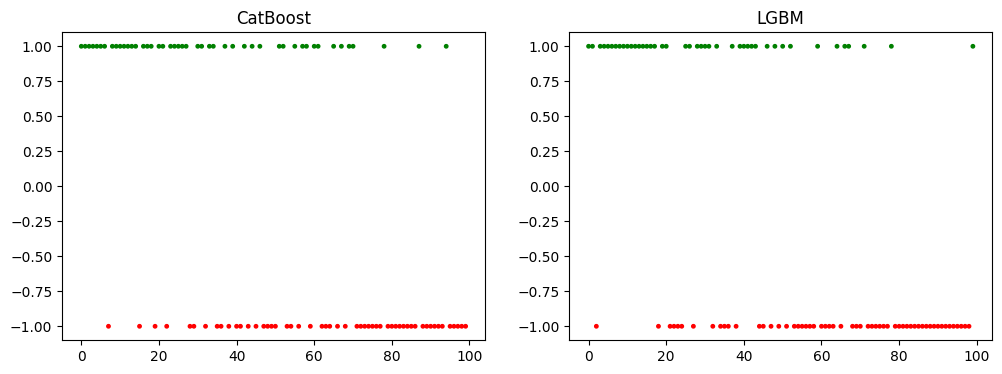

Fold 1


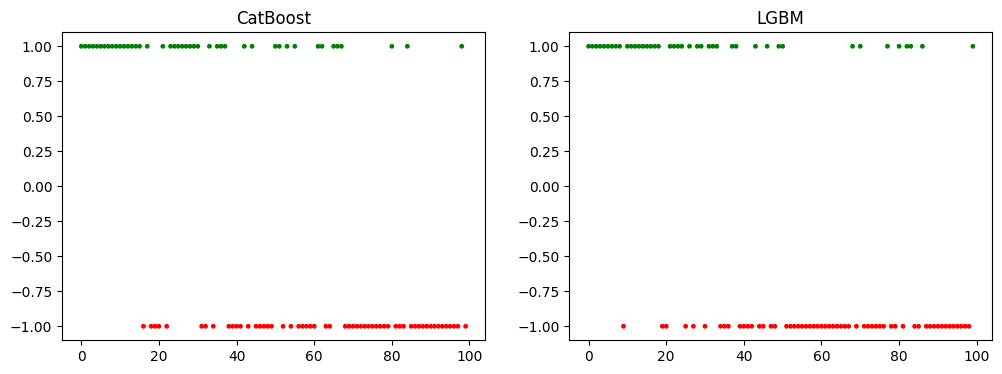

Fold 2


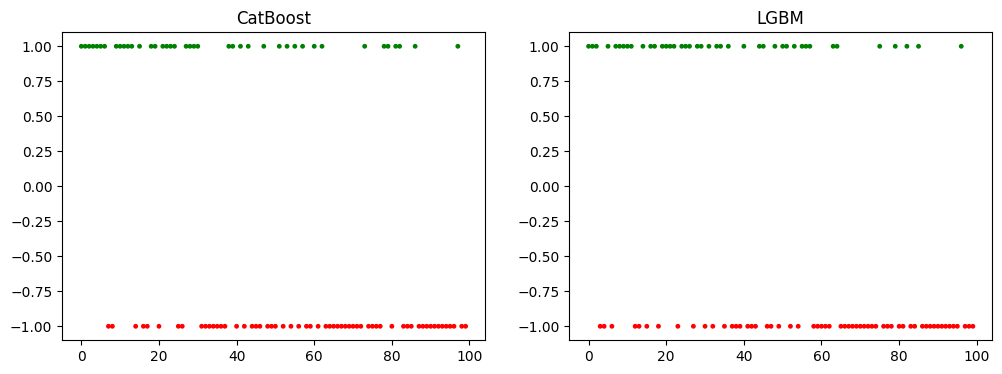

Fold 3


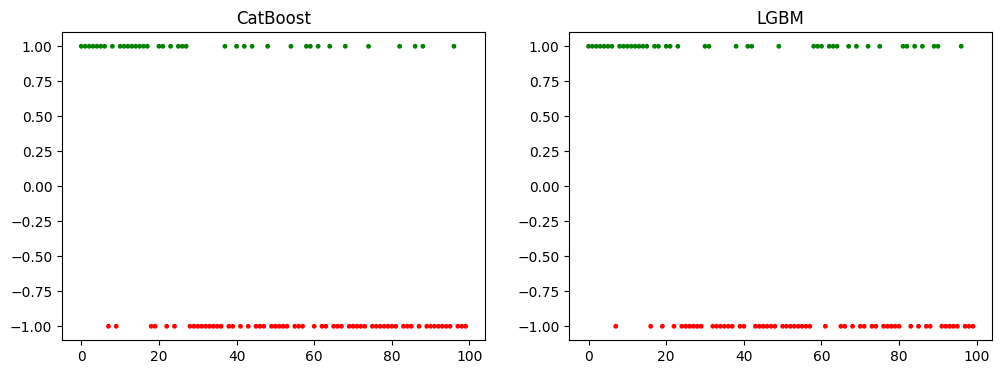

Fold 4


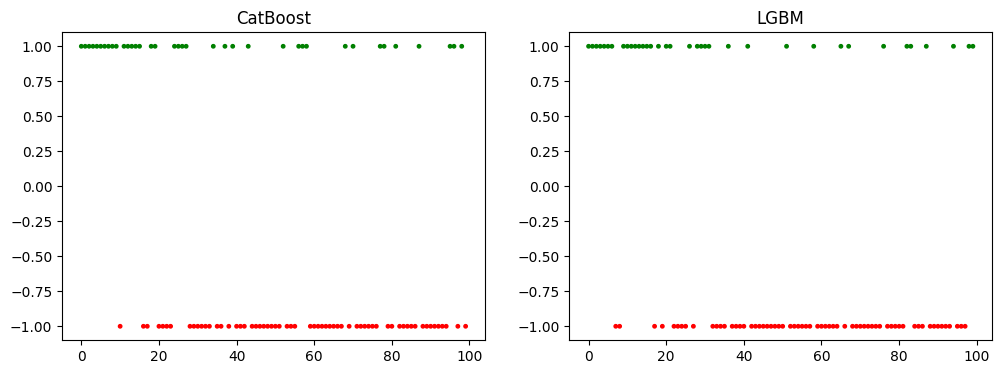

In [14]:

for k in correct:
    print("Fold", k)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    split_correct = correct[k]
    for j, clf in enumerate(split_correct):
        preds = []
        for i in range(100):
            if i in split_correct[clf].keys():
                preds.append(1)
            else:
                preds.append(-1)
        colors = ['green' if x == 1 else 'red' for x in preds]
        ax[j].scatter(range(len(preds)), preds, c=colors, s=6)
        ax[j].set_title(f'{clf}')

    plt.show()
    plt.close()   

In [15]:
for k in correct:
    print("\n\nFold", k)
    common_set = set()
    split_correct = correct[k]
    for clf in split_correct:
        print(f"{clf} found {len(split_correct[clf].keys())} correct")
        if len(common_set) == 0:
            common_set = set(split_correct[clf].values())
        else:
            common_set = common_set.intersection(set(split_correct[clf].values()))
    print("Common Found:", len(common_set))
    print("")
    for clf in split_correct: 
        print(clf)
        for position, idx in split_correct[clf].items():
            if idx not in common_set:
                print(f"Position: {position} -- idx: {idx}")



Fold 0
CatBoost found 47 correct
LGBM found 43 correct
Common Found: 41

CatBoost
Position: 39 -- idx: 24403
Position: 55 -- idx: 60678
Position: 61 -- idx: 92887
Position: 65 -- idx: 118458
Position: 67 -- idx: 37363
Position: 94 -- idx: 21529
LGBM
Position: 59 -- idx: 66595
Position: 67 -- idx: 13041


Fold 1
CatBoost found 44 correct
LGBM found 42 correct
Common Found: 39

CatBoost
Position: 26 -- idx: 9564
Position: 36 -- idx: 102284
Position: 50 -- idx: 103598
Position: 67 -- idx: 73425
Position: 84 -- idx: 113389
LGBM
Position: 80 -- idx: 114024
Position: 86 -- idx: 137345
Position: 99 -- idx: 43251


Fold 2
CatBoost found 41 correct
LGBM found 42 correct
Common Found: 36

CatBoost
Position: 41 -- idx: 27341
Position: 43 -- idx: 73104
Position: 55 -- idx: 26970
Position: 57 -- idx: 56895
Position: 81 -- idx: 119071
LGBM
Position: 34 -- idx: 57208
Position: 45 -- idx: 32902
Position: 56 -- idx: 4878
Position: 75 -- idx: 64186
Position: 82 -- idx: 34656
Position: 96 -- idx: 76982